# 6. Workshop 1-2 : MNIST - CNN

> **[ Reference ] :**
+ FRANÇOIS CHOLLET, **Deep Learning with Python**, Chapter 5, Section 1, Manning, 2018. 
  (https://tanthiamhuat.files.wordpress.com/2018/03/deeplearningwithpython.pdf)
+ 李飛飛教授：Convolutional Neural Networks (教學投影片)
  (http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture5.pdf)
+ 李飛飛教授：Convolutional Neural Networks (CNNs / ConvNets)
  (https://cs231n.github.io/convolutional-networks/)
+ `tf.keras.layers.Conv2D`
  (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
  
----

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

### Using convnet (Convolutional Neural Network, CNN) to classify MNIST digits :

+ **The 6 lines of code below show you what a basic convnet looks like. It's a stack of `Conv2D` and `MaxPooling2D` layers.** 
+ Importantly, a convnet takes as input tensors of shape `(image_height, image_width, image_channels)` (not including the batch dimension). 
+ In our case, we will configure our convnet to process inputs of size `(28, 28, 1)`, which is the format of MNIST images. We do this via passing the argument `input_shape=(28, 28, 1)` to our first layer.

In [3]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# 32 怎麼變 64 的?
# 一組filter大小為3*3、有32個channel，共64組filter
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of our convnet so far:

In [4]:
model.summary()

# 320 = (3*3+1) * 32
# 18496 = (3*3*32+1) * 64

# "+1" 為加bias變數

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


You can see above that the output of every `Conv2D` and `MaxPooling2D` layer is a 3D tensor of shape `(height, width, channels)`. The width 
and height dimensions tend to shrink as we go deeper in the network. The number of channels is controlled by the first argument passed to 
the `Conv2D` layers (e.g. 32 or 64).

The next step would be to feed our last output tensor (of shape `(3, 3, 64)`) into a densely-connected classifier network like those you are 
already familiar with: a stack of `Dense` layers. These classifiers process vectors, which are 1D, whereas our current output is a 3D tensor. 
So first, we will have to flatten our 3D outputs to 1D, and then add a few `Dense` layers on top:

In [5]:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We are going to do 10-way classification, so we use a final layer with 10 outputs and a softmax activation. Now here's what our network 
looks like:

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
__________

As you can see, our `(3, 3, 64)` outputs were flattened into vectors of shape `(576,)`, before going through two `Dense` layers.

Now, let's train our convnet on the MNIST digits. We will reuse a lot of the code we have already covered in the MNIST example from Chapter 
2.

In [16]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
test_labels
# 尚未 to_categorical ：　array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)
# to_categorical之後 ：　array([[0., 0., 0., ..., 1., 0., 0.],
#                              [0., 0., 1., ..., 0., 0., 0.],
#                              [0., 1., 0., ..., 0., 0., 0.],
#                              ...,
#                              [0., 0., 0., ..., 0., 0., 0.],
#                              [0., 0., 0., ..., 0., 0., 0.],
#                              [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [30]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=256)

Epoch 1/5
60000/60000 [==============================] - 6s 108us/step - loss: 0.0021 - acc: 0.9995
Epoch 2/5
60000/60000 [==============================] - 6s 97us/step - loss: 8.8789e-04 - acc: 0.9998
Epoch 3/5
60000/60000 [==============================] - 6s 97us/step - loss: 0.0018 - acc: 0.9995
Epoch 4/5
60000/60000 [==============================] - 6s 97us/step - loss: 0.0018 - acc: 0.9996
Epoch 5/5
60000/60000 [==============================] - 6s 97us/step - loss: 0.0018 - acc: 0.9995


Let's evaluate the model on the test data:

In [31]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 2s 209us/step


In [32]:
test_acc

0.9925

While our densely-connected network from Chapter 2 had a test accuracy of 97.8%, our basic convnet has a test accuracy of 99.3%: we 
decreased our error rate by 68% (relative). Not bad! 

## Prediction

In [33]:
test_predict = model.predict(test_images)
test_predict

array([[1.1153511e-22, 1.6650236e-20, 1.8105879e-21, ..., 1.0000000e+00,
        9.1464976e-23, 3.2096024e-19],
       [1.9469267e-30, 2.5038605e-33, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.4627455e-22, 1.0000000e+00, 3.6572892e-23, ..., 1.0925467e-17,
        2.2278801e-18, 3.8914137e-22],
       ...,
       [9.5761882e-33, 6.2906044e-24, 7.3119945e-32, ..., 3.9485370e-21,
        2.8037864e-24, 2.5534719e-23],
       [1.1008183e-23, 4.3998140e-25, 2.1774577e-34, ..., 4.1253173e-26,
        4.2131708e-18, 2.8028575e-23],
       [1.9650081e-20, 3.1574259e-23, 3.2332392e-23, ..., 5.9708824e-32,
        1.7857491e-22, 5.7574574e-30]], dtype=float32)

In [34]:
import numpy as np
test_predict_result = np.array([np.argmax(test_predict[i]) for i in range(len(test_predict))])
test_predict_result

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [13]:
test_labels_result = np.array([np.argmax(test_labels[i]) for i in range(len(test_predict))])
test_labels_result

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

## Confusion Matrix

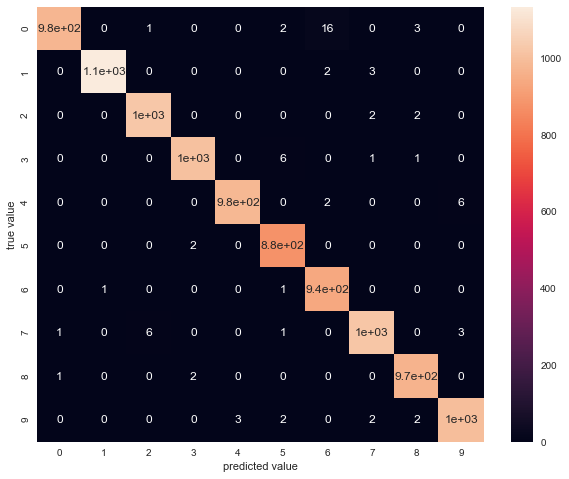

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix

mat = confusion_matrix(test_predict_result, test_labels_result)

plt.figure(figsize=(10,8))
sns.heatmap(mat, square=False, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');